<a href="https://colab.research.google.com/github/matveysiva/I-Sec-Recool/blob/main/DLfVR_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📊 Total number of patients: 369
📝 First 5 patients: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']
📝 Last 5 patients: ['BraTS20_Training_365', 'BraTS20_Training_366', 'BraTS20_Training_367', 'BraTS20_Training_368', 'BraTS20_Training_369']

🎲 Randomly selected patient: BraTS20_Training_228
✅ Loaded FLAIR: shape = (240, 240, 155), min = 0.00, max = 605.00
✅ Loaded T1: shape = (240, 240, 155), min = 0.00, max = 678.00
✅ Loaded T1CE: shape = (240, 240, 155), min = 0.00, max = 1159.00
✅ Loaded T2: shape = (240, 240, 155), min = 0.00, max = 1014.00
✅ Loaded SEGMENTATION: shape = (240, 240, 155)
   Unique labels in segmentation: [0. 1. 2. 4.]

📋 Segmentation Label Meanings:
   0 = Background (healthy brain)
   1 = Necrotic/Non-enhancing tumor core
   2 = Peritumoral edema (swelling)
   4 = GD-enhancing tumor

📊 Label distribution in this patient:
   Label 0: 8,854,173 voxels (99.17%)
   Label 1: 3,342 voxels (0.04%)
   

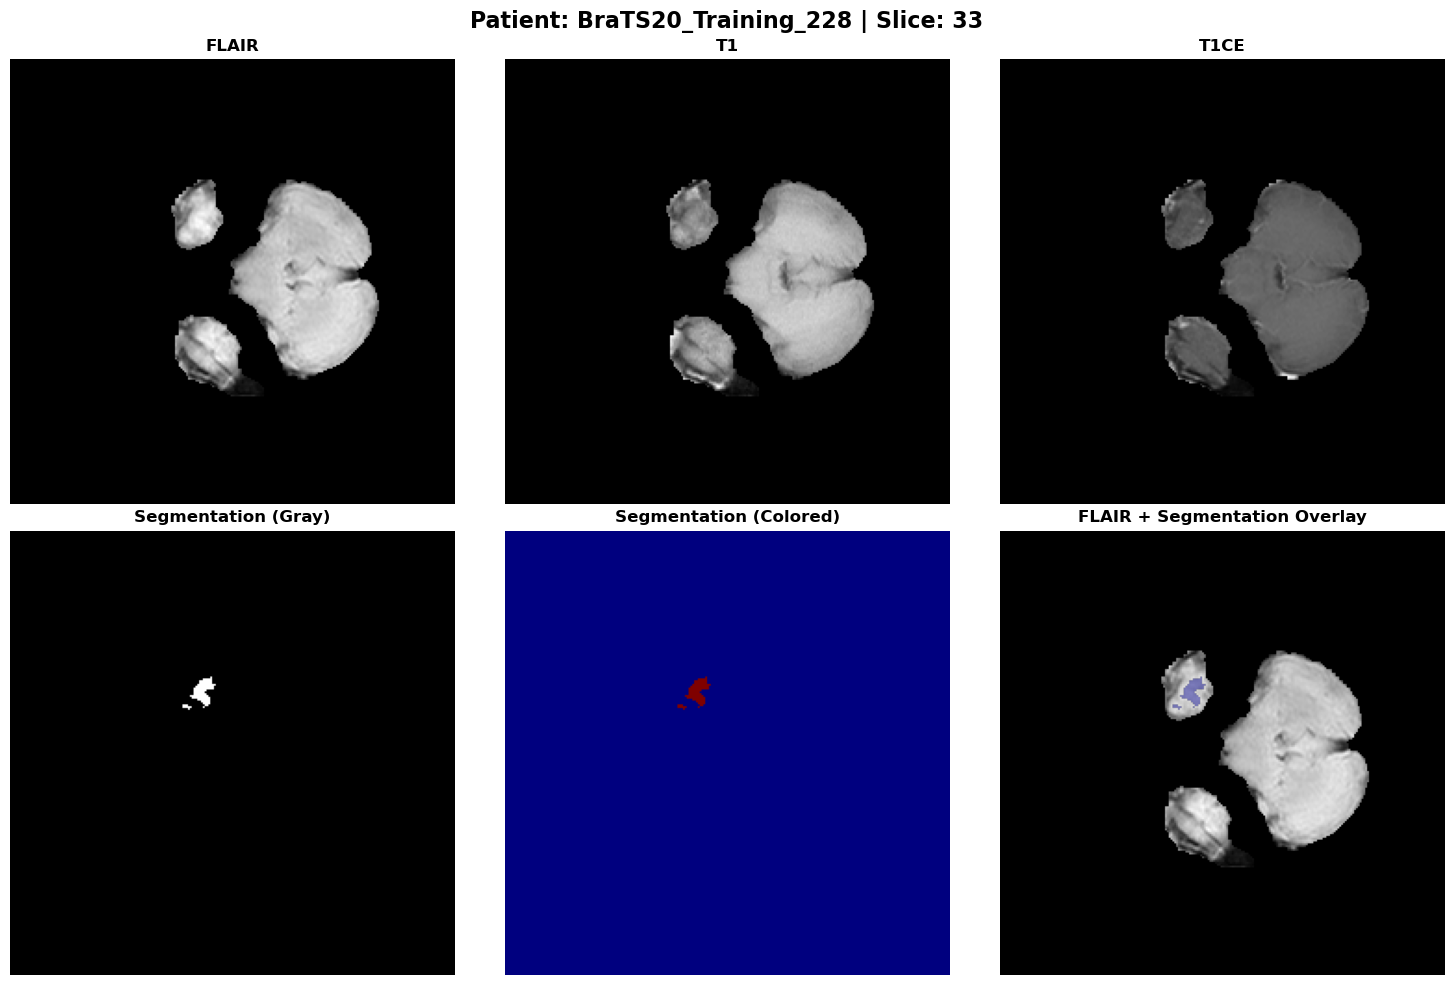


📐 Understanding the 3D structure:
   Each scan is: 240 × 240 × 155
   That's 155 slices, each 240×240 pixels
   We'll train on individual 2D slices for our 2D U-Net approach


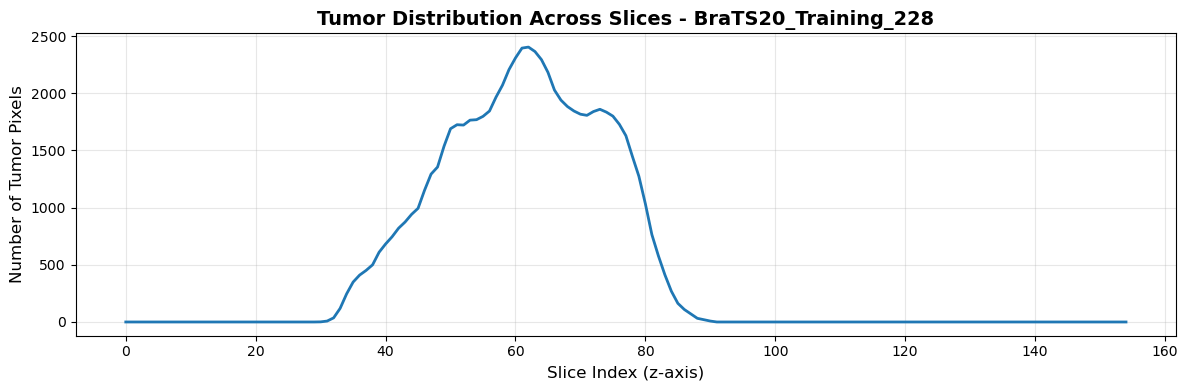


✅ STEP 1 COMPLETE!
You should now see:
  1. 6 images showing different MRI modalities and segmentation
  2. A graph showing which slices contain tumor tissue

Next: We'll create a custom PyTorch Dataset to load this data efficiently!


In [ ]:
# By Adriaan, Arne & Matvey

# ============================================
# STEP 1: DATA EXPLORATION & VISUALIZATION
# ============================================

# Import necessary libraries
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
import random

# Set the path to your training data
DATA_DIR = "archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# ============================================
# 1.1: Check how many patients we have
# ============================================
patient_folders = sorted([d for d in os.listdir(DATA_DIR)
                         if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"📊 Total number of patients: {len(patient_folders)}")
print(f"📝 First 5 patients: {patient_folders[:5]}")
print(f"📝 Last 5 patients: {patient_folders[-5:]}")

# ============================================
# 1.2: Load a random patient's data
# ============================================
# Pick a random patient to visualize
random_patient = random.choice(patient_folders)
print(f"\n🎲 Randomly selected patient: {random_patient}")

patient_path = os.path.join(DATA_DIR, random_patient)

# Load all 4 MRI modalities
modalities = ['flair', 't1', 't1ce', 't2']
images = {}

for modality in modalities:
    file_path = os.path.join(patient_path, f"{random_patient}_{modality}.nii")
    img_data = nib.load(file_path).get_fdata()
    images[modality] = img_data
    print(f"✅ Loaded {modality.upper()}: shape = {img_data.shape}, "
          f"min = {img_data.min():.2f}, max = {img_data.max():.2f}")

# Load segmentation mask
seg_path = os.path.join(patient_path, f"{random_patient}_seg.nii")
seg_data = nib.load(seg_path).get_fdata()
images['seg'] = seg_data

print(f"✅ Loaded SEGMENTATION: shape = {seg_data.shape}")
print(f"   Unique labels in segmentation: {np.unique(seg_data)}")

# ============================================
# 1.3: Understand the segmentation labels
# ============================================
print("\n📋 Segmentation Label Meanings:")
print("   0 = Background (healthy brain)")
print("   1 = Necrotic/Non-enhancing tumor core")
print("   2 = Peritumoral edema (swelling)")
print("   4 = GD-enhancing tumor")

# Count pixels for each label
unique, counts = np.unique(seg_data, return_counts=True)
print("\n📊 Label distribution in this patient:")
for label, count in zip(unique, counts):
    percentage = (count / seg_data.size) * 100
    print(f"   Label {int(label)}: {count:,} voxels ({percentage:.2f}%)")

# ============================================
# 1.4: Visualize a middle slice
# ============================================
# Pick a slice in the middle of the brain (where tumor is likely visible)
middle_slice = seg_data.shape[2] // 2

# Find a slice with tumor present
slice_with_tumor = None
for slice_idx in range(seg_data.shape[2]):
    if np.sum(seg_data[:, :, slice_idx] > 0) > 100:  # Has tumor pixels
        slice_with_tumor = slice_idx
        break

if slice_with_tumor is None:
    slice_with_tumor = middle_slice

print(f"\n🔍 Visualizing slice {slice_with_tumor} (out of {seg_data.shape[2]} total slices)")

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Patient: {random_patient} | Slice: {slice_with_tumor}',
             fontsize=16, fontweight='bold')

# Row 1: Show all 4 modalities
for idx, modality in enumerate(modalities):
    row = idx // 3
    col = idx % 3
    axes[row, col].imshow(images[modality][:, :, slice_with_tumor], cmap='gray')
    axes[row, col].set_title(f'{modality.upper()}', fontsize=12, fontweight='bold')
    axes[row, col].axis('off')

# Row 1, Column 3: Empty (we have 4 modalities)
axes[0, 2].axis('off')

# Row 2, Column 0: Segmentation mask (grayscale)
axes[1, 0].imshow(seg_data[:, :, slice_with_tumor], cmap='gray')
axes[1, 0].set_title('Segmentation (Gray)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Row 2, Column 1: Segmentation mask (colored)
axes[1, 1].imshow(seg_data[:, :, slice_with_tumor], cmap='jet')
axes[1, 1].set_title('Segmentation (Colored)', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

# Row 2, Column 2: Overlay segmentation on FLAIR
overlay = images['flair'][:, :, slice_with_tumor].copy()
mask = seg_data[:, :, slice_with_tumor] > 0
axes[1, 2].imshow(overlay, cmap='gray')
axes[1, 2].imshow(np.ma.masked_where(~mask, seg_data[:, :, slice_with_tumor]),
                  cmap='jet', alpha=0.5)
axes[1, 2].set_title('FLAIR + Segmentation Overlay', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# ============================================
# 1.5: Show 3D structure
# ============================================
print("\n📐 Understanding the 3D structure:")
print(f"   Each scan is: {seg_data.shape[0]} × {seg_data.shape[1]} × {seg_data.shape[2]}")
print(f"   That's {seg_data.shape[2]} slices, each {seg_data.shape[0]}×{seg_data.shape[1]} pixels")
print(f"   We'll train on individual 2D slices for our 2D U-Net approach")

# Show tumor presence across slices
tumor_per_slice = [np.sum(seg_data[:, :, z] > 0) for z in range(seg_data.shape[2])]

plt.figure(figsize=(12, 4))
plt.plot(tumor_per_slice, linewidth=2)
plt.xlabel('Slice Index (z-axis)', fontsize=12)
plt.ylabel('Number of Tumor Pixels', fontsize=12)
plt.title(f'Tumor Distribution Across Slices - {random_patient}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ STEP 1 COMPLETE!")
print("=" * 60)
print("You should now see:")
print("  1. 6 images showing different MRI modalities and segmentation")
print("  2. A graph showing which slices contain tumor tissue")
print("\nNext: We'll create a custom PyTorch Dataset to load this data efficiently!")
print("=" * 60)



📊 Splitting 369 patients into train/val/test...
✅ Train: 258 patients (69.9%)
✅ Val:   55 patients (14.9%)
✅ Test:  56 patients (15.2%)

🔨 Creating dataset objects...
🔄 Initializing dataset with 258 patients...
✅ Dataset ready: 20640 total 2D slices from 258 patients
   Slice range: 50 to 130
🔄 Initializing dataset with 55 patients...
✅ Dataset ready: 4400 total 2D slices from 55 patients
   Slice range: 50 to 130
🔄 Initializing dataset with 56 patients...
✅ Dataset ready: 4480 total 2D slices from 56 patients
   Slice range: 50 to 130

🧪 Testing dataset - loading one sample...
✅ Sample image shape: torch.Size([4, 240, 240]) (4 channels, 240x240)
✅ Sample mask shape: torch.Size([240, 240]) (240x240)
✅ Image dtype: torch.float32, range: [0.000, 1.000]
✅ Mask dtype: torch.int64, unique labels: [0]

📸 Visualizing one sample from the dataset...


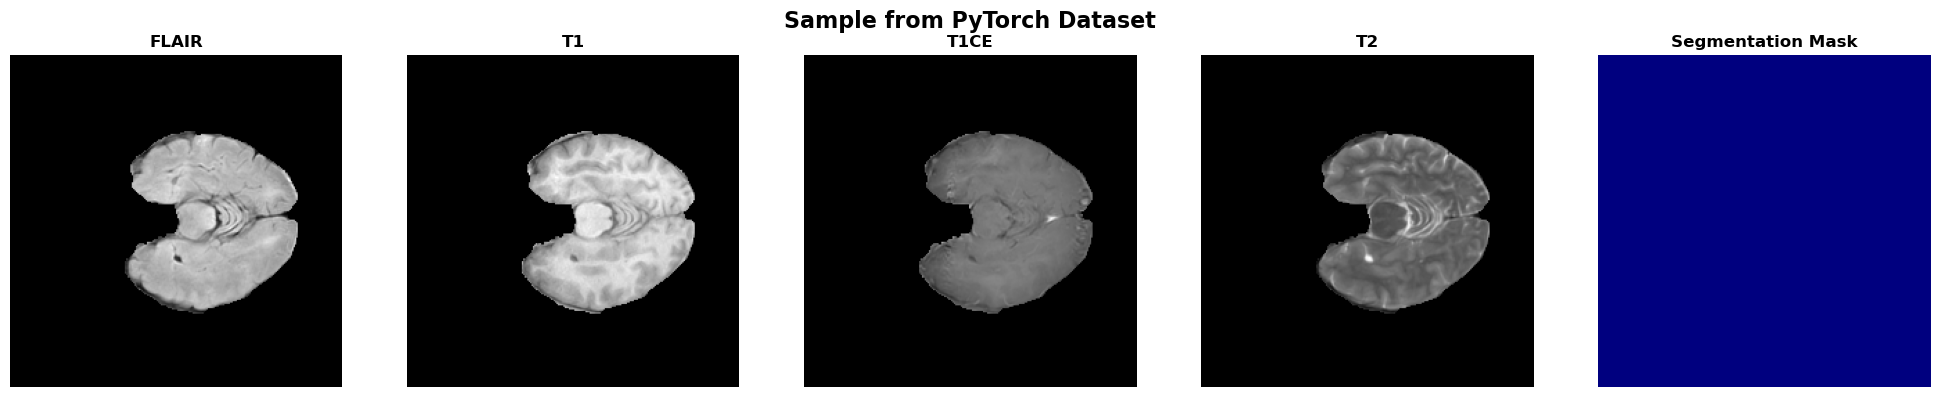


✅ STEP 2 COMPLETE!
What we created:
  ✅ Custom BraTSDataset class
  ✅ Train/Val/Test split (70%/15%/15%)
  ✅ 20640 training slices
  ✅ 4400 validation slices
  ✅ 4480 test slices

Next: We'll create DataLoaders and build the U-Net architecture!


In [ ]:
# ============================================
# STEP 2: CREATE PYTORCH DATASET
# ============================================

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import os

# ============================================
# 2.1: Custom Dataset Class
# ============================================

class BraTSDataset(Dataset):
    """
    Custom PyTorch Dataset for BraTS 2020 brain tumor segmentation.

    Loads 3D MRI volumes and extracts 2D slices for training.
    """

    def __init__(self, patient_list, data_dir, slice_range=(50, 130)):
        """
        Args:
            patient_list: List of patient folder names (e.g., ['BraTS20_Training_001', ...])
            data_dir: Path to the data directory
            slice_range: Tuple (min_slice, max_slice) to focus on brain region with tumors
        """
        self.data_dir = data_dir
        self.slice_range = slice_range
        self.samples = []  # Will store (patient_id, slice_index) pairs

        print(f"🔄 Initializing dataset with {len(patient_list)} patients...")

        # For each patient, identify which slices contain tumor
        for patient_id in patient_list:
            patient_path = os.path.join(data_dir, patient_id)

            # Load segmentation to find slices with tumor
            seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
            seg_data = nib.load(seg_path).get_fdata()

            # Only include slices within our range and with some brain tissue
            for slice_idx in range(slice_range[0], slice_range[1]):
                # Check if this slice has meaningful brain content
                # (we'll include all slices, even without tumor, for better learning)
                if np.sum(seg_data[:, :, slice_idx]) >= 0:  # Any brain tissue
                    self.samples.append((patient_id, slice_idx))

        print(f"✅ Dataset ready: {len(self.samples)} total 2D slices from {len(patient_list)} patients")
        print(f"   Slice range: {slice_range[0]} to {slice_range[1]}")

    def __len__(self):
        """Return total number of samples (2D slices)"""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Load and return one sample (a single 2D slice with 4 channels).

        Returns:
            image: Tensor of shape (4, 240, 240) - 4 MRI modalities
            mask: Tensor of shape (240, 240) - segmentation labels
        """
        patient_id, slice_idx = self.samples[idx]
        patient_path = os.path.join(self.data_dir, patient_id)

        # Load all 4 modalities for this slice
        modalities = ['flair', 't1', 't1ce', 't2']
        image_slices = []

        for modality in modalities:
            file_path = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
            volume = nib.load(file_path).get_fdata()
            slice_2d = volume[:, :, slice_idx]

            # Normalize to [0, 1] range
            slice_2d = self.normalize(slice_2d)
            image_slices.append(slice_2d)

        # Stack into (4, 240, 240) tensor
        image = np.stack(image_slices, axis=0)

        # Load segmentation mask
        seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
        seg_volume = nib.load(seg_path).get_fdata()
        mask = seg_volume[:, :, slice_idx]

        # Convert labels: 0->0, 1->1, 2->2, 4->3 (to have consecutive labels)
        mask[mask == 4] = 3

        # Convert to PyTorch tensors
        image = torch.FloatTensor(image)
        mask = torch.LongTensor(mask.astype(np.int64))

        return image, mask

    def normalize(self, slice_2d):
        """Normalize a 2D slice to [0, 1] range"""
        min_val = slice_2d.min()
        max_val = slice_2d.max()

        if max_val - min_val > 0:
            return (slice_2d - min_val) / (max_val - min_val)
        else:
            return slice_2d


# ============================================
# 2.2: Split data into Train/Val/Test
# ============================================

# Get all patient IDs
DATA_DIR = "archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

all_patients = sorted([d for d in os.listdir(DATA_DIR)
                      if os.path.isdir(os.path.join(DATA_DIR, d))])

print(f"\n📊 Splitting {len(all_patients)} patients into train/val/test...")

# First split: 70% train, 30% temp
train_patients, temp_patients = train_test_split(
    all_patients, test_size=0.30, random_state=42
)

# Second split: split temp into 50/50 (15% val, 15% test of original)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, random_state=42
)

print(f"✅ Train: {len(train_patients)} patients ({len(train_patients)/len(all_patients)*100:.1f}%)")
print(f"✅ Val:   {len(val_patients)} patients ({len(val_patients)/len(all_patients)*100:.1f}%)")
print(f"✅ Test:  {len(test_patients)} patients ({len(test_patients)/len(all_patients)*100:.1f}%)")

# ============================================
# 2.3: Create Dataset objects
# ============================================

print("\n🔨 Creating dataset objects...")

train_dataset = BraTSDataset(train_patients, DATA_DIR, slice_range=(50, 130))
val_dataset = BraTSDataset(val_patients, DATA_DIR, slice_range=(50, 130))
test_dataset = BraTSDataset(test_patients, DATA_DIR, slice_range=(50, 130))

# ============================================
# 2.4: Test loading one sample
# ============================================

print("\n🧪 Testing dataset - loading one sample...")
sample_image, sample_mask = train_dataset[0]

print(f"✅ Sample image shape: {sample_image.shape} (4 channels, 240x240)")
print(f"✅ Sample mask shape: {sample_mask.shape} (240x240)")
print(f"✅ Image dtype: {sample_image.dtype}, range: [{sample_image.min():.3f}, {sample_image.max():.3f}]")
print(f"✅ Mask dtype: {sample_mask.dtype}, unique labels: {torch.unique(sample_mask).numpy()}")

# ============================================
# 2.5: Visualize one sample from dataset
# ============================================

print("\n📸 Visualizing one sample from the dataset...")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Sample from PyTorch Dataset', fontsize=16, fontweight='bold')

# Show each modality
modality_names = ['FLAIR', 'T1', 'T1CE', 'T2']
for i in range(4):
    axes[i].imshow(sample_image[i], cmap='gray')
    axes[i].set_title(modality_names[i], fontsize=12, fontweight='bold')
    axes[i].axis('off')

# Show mask
axes[4].imshow(sample_mask, cmap='jet')
axes[4].set_title('Segmentation Mask', fontsize=12, fontweight='bold')
axes[4].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ STEP 2 COMPLETE!")
print("=" * 60)
print("What we created:")
print("  ✅ Custom BraTSDataset class")
print("  ✅ Train/Val/Test split (70%/15%/15%)")
print(f"  ✅ {len(train_dataset)} training slices")
print(f"  ✅ {len(val_dataset)} validation slices")
print(f"  ✅ {len(test_dataset)} test slices")
print("\nNext: We'll create DataLoaders and build the U-Net architecture!")
print("=" * 60)


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
sample_images = sample_images.to(device)
sample_masks  = sample_masks.to(device)

#BUILD 2D U-NET ARCHITECTURE

#BUILD 2.5D U-NET ARCHITECTURE

#BUILD 3D U-NET ARCHITECTURE (@Adriaan)